# Aligning 3D microscopy image stacks of expanded Paramecium cells
This workflow processes 3D fluorescence microscopy image stacks(TIFF format) of expanded Paramecium cells (using ExM) to align their major axes with the y-axis in both the XY and YZ planes. The goal is to obtain 3D image stacks with cells oriented the same so that we can use the maximum projections of the front and back of the cell to extract the different region (sizes). The pipeline includes preprocessing, brightness/contrast adjustment, maximum intensity projection, contour/ellipse detection, and rotation in multiple planes. The result is a set of rotated and aligned image stacks suitable for further quantitative analysis.

Input:
- raw_data_file: 3D TIFF image stacks of Paramecium cells. Here we imported an image stack of the Centrin channel, and had the image stack of the other channel, Poly-E, present in the same folder to open later.
- Metadata: pixel/voxel size (X_SCALE, Y_SCALE, Z_SCALE)

Output:
- Processed and aligned 3D TIFF image stacks with major axes aligned to the y-axis in both XY and YZ planes
- Intermediate 2D projections and visualizations for quality control

In [1]:
import os
from mayavi import mlab #for vizualization
import matplotlib.colors as colors
import tifffile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from skimage import io
import imageio

In [2]:
# Define Metadata for the data file
# You should be able to get this info in ImageJ from Image > Properties
# ExM WT data
X_SCALE = 2865733e-7    # pixel width
Y_SCALE = 2865733e-7      # pixel height
Z_SCALE = 5890229e-7      # voxel depth

# IF control data
# X_SCALE = 1169596e-7    # pixel width
# Y_SCALE = 1169596e-7      # pixel height
# Z_SCALE = 3164834e-7      # voxel depth

# Additional parameters:
Z_REF = 0
VALUE_THRESHOLD = 0   # to remove background (needs fine-tuning per cell)

In [3]:
def open_tif(file_path):
    """
    Given a tif file path, it stores the z-stack in the array 'image' and
    reads its dimensions, handling both single-channel and multi-channel cases.
    """
    image = tifffile.imread(file_path)

    # Check dimensions to determine if it's a single or multi-channel image
    if len(image.shape) == 3:  # Single-channel (z, x, y)
        num_slices = image.shape[0]
        num_channels = 1
        x_dim, y_dim = image.shape[1], image.shape[2]

    elif len(image.shape) == 4:  # Multi-channel (z, c, x, y)
        num_slices = image.shape[0]
        num_channels = image.shape[1]
        x_dim, y_dim = image.shape[2], image.shape[3]

    else:
        raise ValueError("Unsupported image shape: {}".format(image.shape))

    data_shape = [num_slices, num_channels, x_dim, y_dim]

    return image, data_shape

def preprocess_image(slice, channel_mult, VALUE_THRESHOLD):
    """
    Preprocesses a single image slice, supporting both single and multi-channel cases.
    """
    if slice.ndim == 2:  # Single-channel case
        processed_slice = slice
        processed_slice = (processed_slice - processed_slice.min()) / (processed_slice.max() - processed_slice.min())
        processed_slice[processed_slice < VALUE_THRESHOLD] = 0
        processed_slice[processed_slice >= VALUE_THRESHOLD] = 1

    elif slice.ndim == 3:  # Multi-channel case (3 channels)
        assert len(channel_mult) == 3, "channel_mult should have 3 values for multi-channel images."
        slice = (slice - slice.min()) / (slice.max() - slice.min())  # Normalize

        for i in range(3):
            slice[:, :, i] *= channel_mult[i]  # Apply channel multipliers

        hsv_image = colors.rgb_to_hsv(slice)
        value_channel = hsv_image[:, :, 2]
        processed_slice = np.copy(value_channel)
        processed_slice[processed_slice < VALUE_THRESHOLD] = 0
        processed_slice[processed_slice >= VALUE_THRESHOLD] = 1
    else:
        raise ValueError("Unsupported slice dimensions for preprocessing.")

    return processed_slice

def generate_point_cloud(channels, shape, X_SCALE, Y_SCALE, Z_SCALE, channel_mult=[1, 1, 1], VALUE_THRESHOLD=0.33):
    point_cloud = []
    for z in range(shape[0]):
        if shape[1] == 1:
            curr_img = channels[z, :, :]  # Single-channel case
        else:
            curr_img = channels[z, :, :, :]  # Multi-channel case

        processed_img = preprocess_image(curr_img, channel_mult=channel_mult, VALUE_THRESHOLD=VALUE_THRESHOLD)

        for i in range(processed_img.shape[0]):
            for j in range(processed_img.shape[1]):
                if processed_img[i, j] != 0.0:
                    loc = pixel_to_xyz(X=i, Y=j, Z=z, X_SCALE=X_SCALE, Y_SCALE=Y_SCALE, Z_SCALE=Z_SCALE)
                    point_cloud.append(loc)

    print("Point Cloud is Generated!")
    return np.transpose(point_cloud)

def pixel_to_xyz(X, Y, Z, X_SCALE, Y_SCALE, Z_SCALE):
    return np.array([X * X_SCALE, Y * Y_SCALE, Z * Z_SCALE])

def visualize_pointcloud(data, title=None, fig_id=1):
    x = data[0, :]
    y = data[1, :]
    z = data[2, :]

    if title is None:
        title = "Point Cloud"

    # Visualize it with mlab.surf
    col = z
    fig = mlab.figure(fig_id, bgcolor=(0, 0, 0), size=(128 * 5, 128 * 5))
    mlab.points3d(x, y, z, col, mode="point", colormap='spectral', figure=fig)
    mlab.title(title, height=0.1, size=0.4)
    mlab.show()  # Show the visualization window

In [66]:
#tiff file
# raw_data_file = 'W:/Users/Daphne/DATA FOR APS/control_data/control_IF/centrin_channels/050225_ptetRNAi_IF_control2_centrin_40xw_117x117x316_001.nd2 - 1_centrin.tif'
raw_data_file = "W:\\Users\\Daphne\\WT_RESULTS\\WT_ExM_Centrin\\Zone analysis\\ExM_ptetWT_Centrin_cell24_centrin.tif"

image, data_shape = open_tif(raw_data_file)

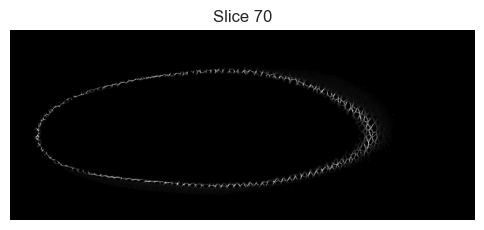

Processed Z-stack saved as processed_z_stack_single_channel.tiff


In [67]:
def process_z_stack(tiff_file, min_val, max_val, slice_number):
    """
    Processes a single-channel Z-stack .tiff file by applying brightness and contrast adjustments
    and visualizes a given slice.

    Args:
        tiff_file (str): Path to the Z-stack .tiff file.
        min_val (int): Minimum displayed value for brightness and contrast adjustment.
        max_val (int): Maximum displayed value for brightness and contrast adjustment.
        slice_number (int): Slice number to visualize.
    """
    # Load the Z-stack images
    stack = tifffile.imread(tiff_file)

    # Ensure slice number is within bounds
    if slice_number < 0 or slice_number >= stack.shape[0]:
        raise ValueError("Slice number is out of bounds")

    # Apply B&C to a given channel image
    def apply_bc(image, min_val, max_val):
        image = np.clip(image, min_val, max_val)
        image = ((image - min_val) / (max_val - min_val) * 255).astype(np.uint8)
        return image

    # Process the entire stack
    processed_stack = np.array([apply_bc(slice, min_val, max_val) for slice in stack])

    # Visualization of the specified slice
    plt.figure(figsize=(6, 6))
    plt.title(f'Slice {slice_number}')
    plt.imshow(processed_stack[slice_number, :, :], cmap='gray')
    plt.axis('off')
    plt.show()

    return processed_stack

# Parameters for brightness and contrast adjustment
min_val = 35
max_val = 500
slice_number = 70

# Process the Z-stack and visualize the specified slice
processed_stack = process_z_stack(raw_data_file, min_val, max_val, slice_number)

# Save the processed stack as a new .tiff file/
output_file = 'processed_z_stack_single_channel.tiff'
tifffile.imwrite(output_file, processed_stack)
print(f'Processed Z-stack saved as {output_file}')

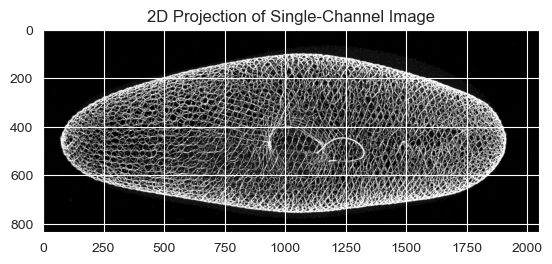

In [68]:
# Assuming `processed_stack` is a 3D array [slices, height, width] for a single-channel image stack
# Create a maximum intensity projection for the single-channel stack
projection_2d = np.max(processed_stack, axis=0)

# Display the 2D projection
plt.imshow(projection_2d, cmap='gray')
plt.title('2D Projection of Single-Channel Image')
plt.show()

##### 1st rotation: Align the major axis of the cell (in XY) with the y-axis of the image

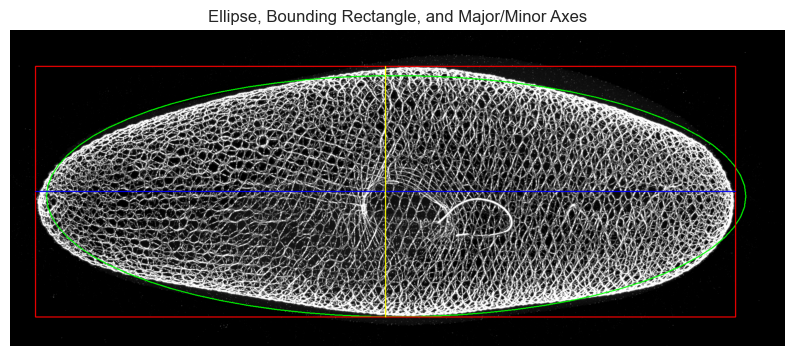

Major Axis: (array([1917. ,  428.5]), array([ 67. , 428.5]))
Width: 661.0, Length: 1850.0
Center: (992.0, 428.5)
Major Axis Vector: Start [1917.   428.5], End [ 67.  428.5]


In [69]:
# def preprocess_2d_projection(projection_2d_1, blur_size=9, canny_min=170, canny_max=200, close_size=5):
def preprocess_2d_projection(projection_2d_1, blur_size=3, canny_min=170, canny_max=200, close_size=5):
    if projection_2d_1 is None:
        raise ValueError("Input image is empty or not loaded correctly.")

    blur = cv2.blur(projection_2d_1, (blur_size, blur_size))
    canny = cv2.Canny(blur.astype(np.uint8), canny_min, canny_max)
    kernel = np.ones((close_size, close_size), np.uint8)
    closing = cv2.morphologyEx(canny, cv2.MORPH_DILATE, kernel)
    return closing

def find_shape(projection_2d_1, display=True):
    closing = preprocess_2d_projection(projection_2d_1)
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Check if contours list is empty
    if not contours:
        print("No contours found in the image.")
        return None, None

    longest_contour = max(contours, key=cv2.contourArea)

    if len(longest_contour) >= 5:
        ellipse = cv2.fitEllipse(longest_contour)
        image_ellipse = cv2.cvtColor(projection_2d_1, cv2.COLOR_GRAY2BGR)  # Convert to BGR to draw colored shapes
        cv2.ellipse(image_ellipse, ellipse, (0, 255, 0), 2)  # Draw in green

        # Draw the minimum bounding rectangle
        rect = cv2.minAreaRect(longest_contour)
        box = cv2.boxPoints(rect)
        box = np.int32(box)
        cv2.drawContours(image_ellipse, [box], 0, (0, 0, 255), 2)  # Draw in red

        # Calculate major axis, width, and length
        center, size, angle = rect
        width, length = size if size[0] < size[1] else size[::-1]
        major_axis = length  # The longer side of the rectangle

        # Calculate the major axis vector
        rect_center = np.array(center)
        half_major_axis_vector = np.array([-np.sin(np.deg2rad(angle)), np.cos(np.deg2rad(angle))]) * (major_axis / 2)
        major_axis_start = rect_center - half_major_axis_vector
        major_axis_end = rect_center + half_major_axis_vector

        # Calculate the minor axis vector
        half_minor_axis_vector = np.array([np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle))]) * (width / 2)
        minor_axis_start = rect_center - half_minor_axis_vector
        minor_axis_end = rect_center + half_minor_axis_vector

        # Draw the major axis
        cv2.line(image_ellipse, tuple(major_axis_start.astype(int)), tuple(major_axis_end.astype(int)), (255, 0, 0), 2)  # Draw in blue
        # Draw the minor axis
        cv2.line(image_ellipse, tuple(minor_axis_start.astype(int)), tuple(minor_axis_end.astype(int)), (0, 255, 255), 2)  # Draw in yellow

        if display:
            # Display the result using matplotlib
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(image_ellipse, cv2.COLOR_BGR2RGB))
            plt.title("Ellipse, Bounding Rectangle, and Major/Minor Axes")
            plt.axis('off')
            plt.show()

        return rect, (major_axis_start, major_axis_end)
    else:
        print("Not enough points to fit an ellipse.")
        return None, None, None, None, None, None, None



# Find shape and draw axes
rect, major_axis_vector = find_shape(projection_2d, display=True)

if major_axis_vector is not None:
    (center), (width, length), angle = rect
    print(f"Major Axis: {major_axis_vector}")
    print(f"Width: {width}, Length: {length}")
    print(f"Center: {center}")
    print(f"Major Axis Vector: Start {major_axis_vector[0]}, End {major_axis_vector[1]}")
else:
    print("Could not find a valid shape in the image.")

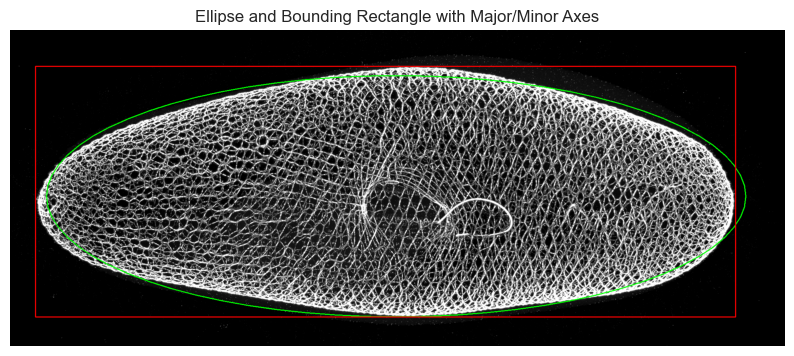

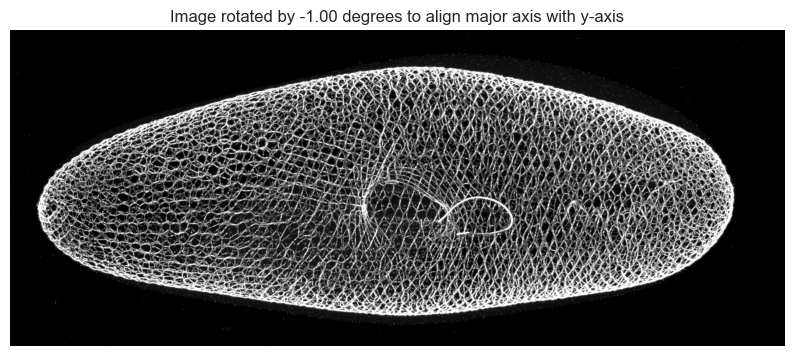

In [74]:
# def preprocess_2d_projection(projection_2d_1, blur_size=9, canny_min=170, canny_max=200, close_size=5):
def preprocess_2d_projection(projection_2d_1, blur_size=3, canny_min=170, canny_max=200, close_size=5):
    if projection_2d_1 is None:
        raise ValueError("Input image is empty or not loaded correctly.")

    blur = cv2.blur(projection_2d_1, (blur_size, blur_size))
    canny = cv2.Canny(blur.astype(np.uint8), canny_min, canny_max)
    kernel = np.ones((close_size, close_size), np.uint8)
    closing = cv2.morphologyEx(canny, cv2.MORPH_DILATE, kernel)
    return closing

def find_shape(projection_2d_1, display=True):
    closing = preprocess_2d_projection(projection_2d_1)
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    longest_contour = max(contours, key=cv2.contourArea)

    if len(longest_contour) >= 5:
        ellipse = cv2.fitEllipse(longest_contour)
        image_ellipse = cv2.cvtColor(projection_2d_1, cv2.COLOR_GRAY2BGR)
        cv2.ellipse(image_ellipse, ellipse, (0, 255, 0), 2)

        rect = cv2.minAreaRect(longest_contour)
        box = cv2.boxPoints(rect)
        box = np.int32(box)
        cv2.drawContours(image_ellipse, [box], 0, (0, 0, 255), 2)

        center, size, angle = rect
        width, length = size if size[0] < size[1] else size[::-1]
        major_axis = length

        rect_center = np.array(center)
        half_major_axis_vector = np.array([-np.sin(np.deg2rad(angle)), np.cos(np.deg2rad(angle))]) * (major_axis / 2)
        major_axis_start = rect_center - half_major_axis_vector
        major_axis_end = rect_center + half_major_axis_vector

        if display:
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(image_ellipse, cv2.COLOR_BGR2RGB))
            plt.title("Ellipse and Bounding Rectangle with Major/Minor Axes")
            plt.axis('off')
            plt.show()

        return rect, (major_axis_start, major_axis_end)
    else:
        print("Not enough points to fit an ellipse.")
        return None, None

def rotate_image_to_align_major_axis_with_y_axis(image, rect, major_axis_vector):
    center, size, angle = rect

    # Calculate the rotation angle required to align the major axis with the y-axis
    major_axis_start, major_axis_end = major_axis_vector
    dx, dy = major_axis_end - major_axis_start
    rotation_angle = -np.degrees(np.arctan2(dx, dy)) -89  # Calculate angle relative to y-axis
    # rotation_angle = 12 # manually adjust

    # Rotate the image to align major axis with the y-axis (invert the angle for correct direction)
    rot_matrix = cv2.getRotationMatrix2D(tuple(center), rotation_angle, scale=1.0)
    rotated_image = cv2.warpAffine(image, rot_matrix, (image.shape[1], image.shape[0]))

    return rotated_image, rotation_angle

# Find shape and draw axes
rect, major_axis_vector = find_shape(projection_2d, display=True)

if major_axis_vector is not None:
    rotated_image, rotation_angle = rotate_image_to_align_major_axis_with_y_axis(projection_2d, rect, major_axis_vector)

    # Display the rotated result
    plt.figure(figsize=(10, 10))
    plt.imshow(rotated_image, cmap="gray")
    plt.title(f"Image rotated by {-rotation_angle:.2f} degrees to align major axis with y-axis")
    plt.axis('off')
    plt.show()
else:
    print("Could not find a valid shape in the image.")

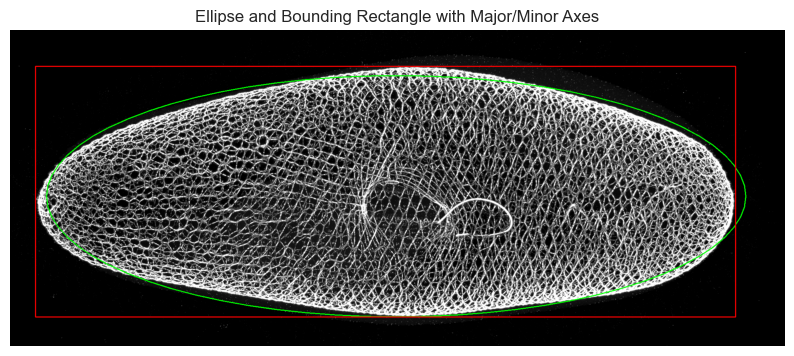

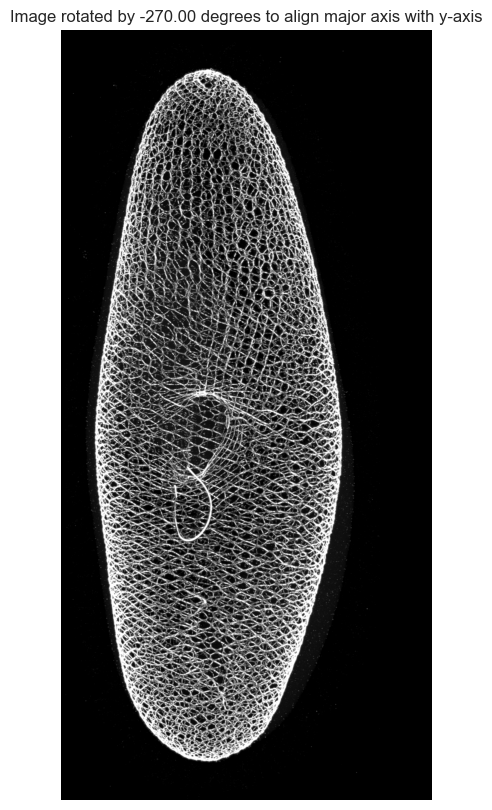

In [77]:
# # IF THE ROTATED CELL IS NOT FULLY INSIDE THE IMAGE, THEN INCREASE THE IMAGE SIZE
#
# def preprocess_2d_projection(projection_2d_1, blur_size=3, canny_min=170, canny_max=200, close_size=5):
def preprocess_2d_projection(projection_2d_1, blur_size=3, canny_min=170, canny_max=200, close_size=5):
    if projection_2d_1 is None:
        raise ValueError("Input image is empty or not loaded correctly.")

    blur = cv2.blur(projection_2d_1, (blur_size, blur_size))
    canny = cv2.Canny(blur.astype(np.uint8), canny_min, canny_max)
    kernel = np.ones((close_size, close_size), np.uint8)
    closing = cv2.morphologyEx(canny, cv2.MORPH_DILATE, kernel)
    return closing

def find_shape(projection_2d_1, display=True):
    closing = preprocess_2d_projection(projection_2d_1)
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    longest_contour = max(contours, key=cv2.contourArea)

    if len(longest_contour) >= 5:
        ellipse = cv2.fitEllipse(longest_contour)
        image_ellipse = cv2.cvtColor(projection_2d_1, cv2.COLOR_GRAY2BGR)
        cv2.ellipse(image_ellipse, ellipse, (0, 255, 0), 2)

        rect = cv2.minAreaRect(longest_contour)
        box = cv2.boxPoints(rect)
        box = np.int32(box)
        cv2.drawContours(image_ellipse, [box], 0, (0, 0, 255), 2)

        center, size, angle = rect
        width, length = size if size[0] < size[1] else size[::-1]
        major_axis = length

        rect_center = np.array(center)
        half_major_axis_vector = np.array([-np.sin(np.deg2rad(angle)), np.cos(np.deg2rad(angle))]) * (major_axis / 2)
        major_axis_start = rect_center - half_major_axis_vector
        major_axis_end = rect_center + half_major_axis_vector

        if display:
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(image_ellipse, cv2.COLOR_BGR2RGB))
            plt.title("Ellipse and Bounding Rectangle with Major/Minor Axes")
            plt.axis('off')
            plt.show()

        return rect, (major_axis_start, major_axis_end)
    else:
        print("Not enough points to fit an ellipse.")
        return None, None

def rotate_image_to_align_major_axis_with_y_axis(image, rect, major_axis_vector):
    center, size, angle = rect

    # Calculate the rotation angle required to align the major axis with the y-axis
    major_axis_start, major_axis_end = major_axis_vector
    dx, dy = major_axis_end - major_axis_start
    rotation_angle = -np.degrees(np.arctan2(dx, dy)) +180 # Calculate angle relative to y-axis
    # rotation_angle = 25 # manually adjust

    # Calculate the sine and cosine of the rotation angle
    cos = np.abs(np.cos(np.deg2rad(rotation_angle)))
    sin = np.abs(np.sin(np.deg2rad(rotation_angle)))

    # Compute the new bounding dimensions of the image
    new_w = int((image.shape[0] * sin) + (image.shape[1] * cos))
    new_h = int((image.shape[0] * cos) + (image.shape[1] * sin))

    # Adjust the rotation matrix to take into account the translation
    rot_matrix = cv2.getRotationMatrix2D(tuple(center), rotation_angle, scale=1.0)
    rot_matrix[0, 2] += (new_w / 2) - center[0]
    rot_matrix[1, 2] += (new_h / 2) - center[1]

    # Rotate the image to align major axis with the y-axis (invert the angle for correct direction)
    rotated_image = cv2.warpAffine(image, rot_matrix, (new_w+150, new_h))

    # # Rotate the image to align major axis with the y-axis (invert the angle for correct direction)
    # rot_matrix = cv2.getRotationMatrix2D(tuple(center), rotation_angle, scale=1.0)
    # rotated_image = cv2.warpAffine(image, rot_matrix, (image.shape[1], image.shape[0]))

    return rotated_image, rotation_angle

# Find shape and draw axes
rect, major_axis_vector = find_shape(projection_2d, display=True)

if major_axis_vector is not None:
    rotated_image, rotation_angle = rotate_image_to_align_major_axis_with_y_axis(projection_2d, rect, major_axis_vector)

    # Display the rotated result
    plt.figure(figsize=(10, 10))
    plt.imshow(rotated_image, cmap="gray")
    plt.title(f"Image rotated by {-rotation_angle:.2f} degrees to align major axis with y-axis")
    plt.axis('off')
    plt.show()
else:
    print("Could not find a valid shape in the image.")

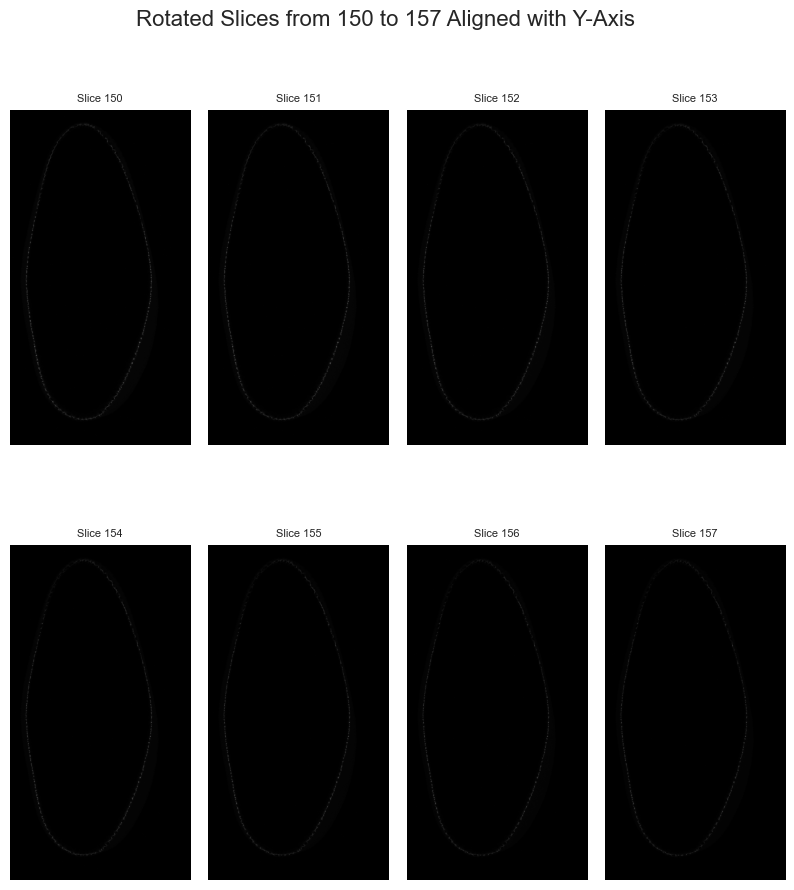

C:\Users\laan\AppData\Local\Temp\ipykernel_29396\4055351084.py:54: UserWarning: rotated_slices_xy_centrin.tif is a low contrast image
  io.imsave(output_tiff_file, np.array(rotated_slices))
C:\Users\laan\AppData\Local\Temp\ipykernel_29396\4055351084.py:55: UserWarning: W:\Users\Daphne\WT_RESULTS\WT_ExM_Centrin\Zone analysis\ExM_ptetWT_Centrin_cell24_centrin_rotated_xy.tif is a low contrast image
  io.imsave(raw_data_file[:-4] + '_rotated_xy.tif', np.array(rotated_slices))


In [78]:
def rotate_slice(image, angle, center):
    # Rotate the image slice around its center by the specified angle
    rot_matrix = cv2.getRotationMatrix2D(tuple(center), angle, scale=1.0)

    # rotated_image = cv2.warpAffine(image, rot_matrix, (image.shape[1], image.shape[0]))

        # Calculate the sine and cosine of the rotation angle
    cos = np.abs(np.cos(np.deg2rad(rotation_angle)))
    sin = np.abs(np.sin(np.deg2rad(rotation_angle)))

    # Compute the new bounding dimensions of the image
    new_w = int((image.shape[0] * sin) + (image.shape[1] * cos))
    new_h = int((image.shape[0] * cos) + (image.shape[1] * sin))

    # Adjust the rotation matrix to take into account the translation
    rot_matrix = cv2.getRotationMatrix2D(tuple(center), rotation_angle, scale=1.0)
    rot_matrix[0, 2] += (new_w / 2) - center[0]
    rot_matrix[1, 2] += (new_h / 2) - center[1]
    rotated_image = cv2.warpAffine(image, rot_matrix, (new_w+100, new_h))
    return rotated_image

# Load the TIFF file as a 3D array (num_slices, x_dim, y_dim)
# tiff_stack = io.imread(output_file) #this is the preprocessed image stack
tiff_stack = io.imread(raw_data_file)

# Center of the images (assuming all slices have the same dimensions)
center = (tiff_stack.shape[2] / 2, tiff_stack.shape[1] / 2)

# Rotate each slice by the pre-calculated angle
rotated_slices = [rotate_slice(slice, rotation_angle, center) for slice in tiff_stack]

# Define the range of slices to display (150 to 157 inclusive)
start_slice = 150
end_slice = 157

# Display the selected range of rotated slices
plt.figure(figsize=(10, 10))
num_slices_to_display = end_slice - start_slice + 1
cols = 4
rows = (num_slices_to_display + cols - 1) // cols

for i, rotated_slice in enumerate(rotated_slices[start_slice:end_slice + 1]):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(rotated_slice, cmap='gray', aspect='auto')
    plt.title(f"Slice {start_slice + i}", fontsize=8)
    plt.axis('off')

plt.suptitle(f"Rotated Slices from {start_slice} to {end_slice} Aligned with Y-Axis", fontsize=16)
plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Increase space between subplots
plt.show()


output_tiff_file = 'rotated_slices_xy_centrin.tif'
io.imsave(output_tiff_file, np.array(rotated_slices))
io.imsave(raw_data_file[:-4] + '_rotated_xy.tif', np.array(rotated_slices))

In [79]:
# Find matching files by size (the poly-E channel) IF NOT SAME SIZE, THEN IMPORT THE POLY-E CHANNEL
def find_matching_files_by_size(folder_path, original_file, tolerance=1):
    # Get the size of the original file in KB
    original_file_size = os.path.getsize(original_file) / 1024  # Convert bytes to KB
    original_file_name = os.path.basename(original_file)  # Original file name

    # Print the size of the original file
    print(f"Original file: {original_file_name} - Size: {original_file_size:.2f} KB")

    # List to store paths of matching files
    matching_files = []

    # Iterate over files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Check if file is a TIFF, has the same size (within tolerance), is not the original, and doesn't contain "rotated"
        if filename.endswith('.tif') and filename != original_file_name and "rotated" not in filename:
            current_file_size = os.path.getsize(file_path) / 1024  # Get size in KB
            if abs(current_file_size - original_file_size) <= tolerance:
                matching_files.append((file_path, current_file_size))
                print(f"Matching file found: {file_path} - Size: {current_file_size:.2f} KB")

    return matching_files

# Example usage
# folder_path = './'  # Adjust as needed
folder_path = 'W:\\Users\\Daphne\\WT_RESULTS\\WT_ExM_Centrin\\Zone analysis\\'  # Adjust as needed
original_file = os.path.join(folder_path, raw_data_file)
matching_files = find_matching_files_by_size(folder_path, original_file)

Original file: ExM_ptetWT_Centrin_cell24_centrin.tif - Size: 1217343.29 KB
Matching file found: W:\Users\Daphne\WT_RESULTS\WT_ExM_Centrin\Zone analysis\ExM_ptetWT_Centrin_cell24_polye.tif - Size: 1217343.29 KB


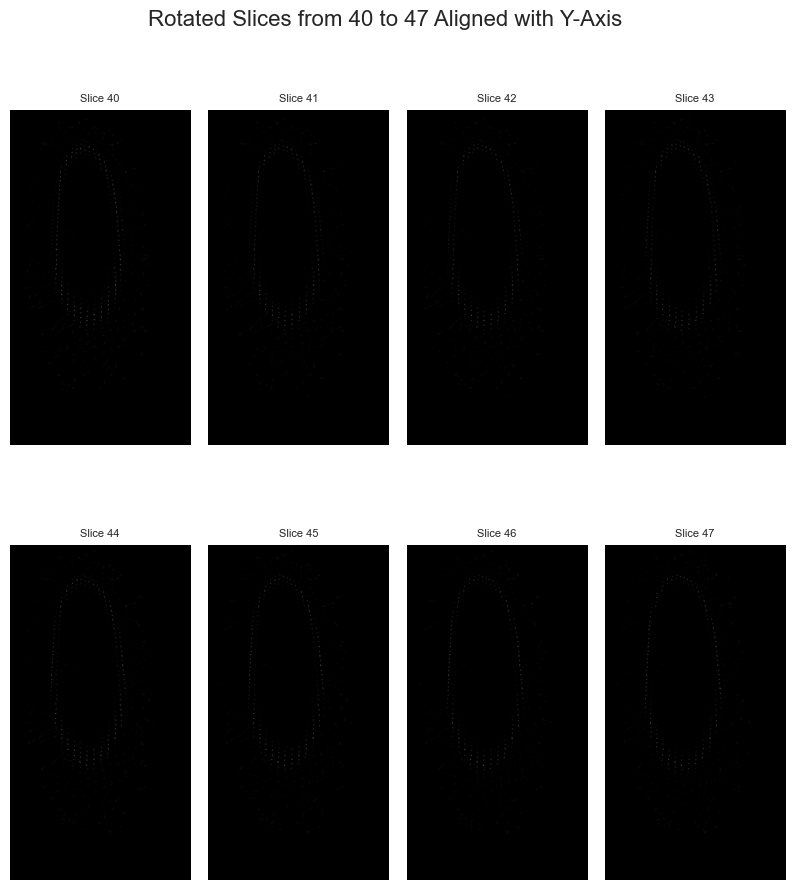

C:\Users\laan\AppData\Local\Temp\ipykernel_29396\2547442438.py:28: UserWarning: rotated_slices_xy_polyE.tif is a low contrast image
  io.imsave(output_tiff_file_2, np.array(rotated_slices_2))
C:\Users\laan\AppData\Local\Temp\ipykernel_29396\2547442438.py:29: UserWarning: W:\Users\Daphne\WT_RESULTS\WT_ExM_Centrin\Zone analysis\ExM_ptetWT_Centrin_cell24_polye_rotated_xy.tif is a low contrast image
  io.imsave(matching_files[0][0][:-4] + '_rotated_xy.tif', np.array(rotated_slices_2))


In [80]:
# Apply the rotation to the matching file(s)
tiff_stack_2 = io.imread(matching_files[0][0])
center_2 = (tiff_stack_2.shape[2] / 2, tiff_stack_2.shape[1] / 2)
rotated_slices_2 = [rotate_slice(slice, rotation_angle, center_2) for slice in tiff_stack_2]

# Define the range of slices to display (150 to 157 inclusive)
start_slice = 40
end_slice = 47

# Display the selected range of rotated slices
plt.figure(figsize=(10, 10))
num_slices_to_display = end_slice - start_slice + 1
cols = 4
rows = (num_slices_to_display + cols - 1) // cols

for i, rotated_slice_2 in enumerate(rotated_slices_2[start_slice:end_slice + 1]):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(rotated_slice_2, cmap='gray', aspect='auto')
    plt.title(f"Slice {start_slice + i}", fontsize=8)
    plt.axis('off')

plt.suptitle(f"Rotated Slices from {start_slice} to {end_slice} Aligned with Y-Axis", fontsize=16)
plt.subplots_adjust(wspace=0.1, hspace=0.3)  # Increase space between subplots
plt.show()


output_tiff_file_2 = 'rotated_slices_xy_polyE.tif'
io.imsave(output_tiff_file_2, np.array(rotated_slices_2))
io.imsave(matching_files[0][0][:-4] + '_rotated_xy.tif', np.array(rotated_slices_2))

##### 2nd rotation: Align the major axis of the cell (in YZ) with the y-axis of the image

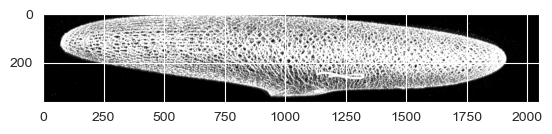

In [81]:
# Max projection in YZ axis
def max_projection_yz(stack):
    return np.max(stack, axis=1)

# Load the TIFF stack
tiff_stack = processed_stack

# Generate the maximum intensity projection in the yz axis
projection_yz = max_projection_yz(tiff_stack)

# Display the maximum intensity projection
plt.imshow(projection_yz, cmap='gray')

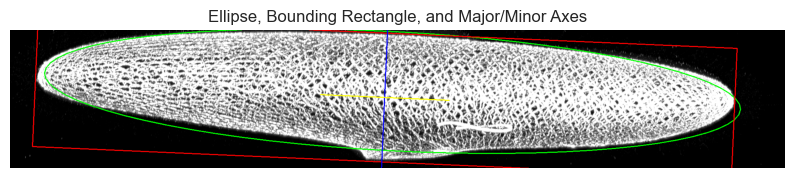

Major Axis: (array([1030.73252092, -745.49605463]), array([ 949.41921248, 1101.47759149]))
Width: 1848.7626953125, Length: 340.42498779296875
Center: (990.0758666992188, 177.9907684326172)
Major Axis Vector: Start [1030.73252092 -745.49605463], End [ 949.41921248 1101.47759149]


In [82]:
# def preprocess_2d_projection(projection_2d_1, blur_size=9, canny_min=170, canny_max=200, close_size=5):
def preprocess_2d_projection(projection_2d_1, blur_size=3, canny_min=170, canny_max=200, close_size=5):
    if projection_2d_1 is None:
        raise ValueError("Input image is empty or not loaded correctly.")

    blur = cv2.blur(projection_2d_1, (blur_size, blur_size))
    canny = cv2.Canny(blur.astype(np.uint8), canny_min, canny_max)
    kernel = np.ones((close_size, close_size), np.uint8)
    closing = cv2.morphologyEx(canny, cv2.MORPH_DILATE, kernel)
    return closing

def find_shape(projection_2d_1, display=True):
    closing = preprocess_2d_projection(projection_2d_1)
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    longest_contour = max(contours, key=cv2.contourArea)

    if len(longest_contour) >= 5:
        ellipse = cv2.fitEllipse(longest_contour)
        image_ellipse = cv2.cvtColor(projection_2d_1, cv2.COLOR_GRAY2BGR)  # Convert to BGR to draw colored shapes
        cv2.ellipse(image_ellipse, ellipse, (0, 255, 0), 2)  # Draw in green

        # Draw the minimum bounding rectangle
        rect = cv2.minAreaRect(longest_contour)
        box = cv2.boxPoints(rect)
        box = np.int32(box)
        cv2.drawContours(image_ellipse, [box], 0, (0, 0, 255), 2)  # Draw in red

        # Calculate major axis, width, and length
        center, size, angle = rect
        width, length = size if size[0] < size[1] else size[::-1]
        major_axis = length  # The longer side of the rectangle

        # Calculate the major axis vector
        rect_center = np.array(center)
        half_major_axis_vector = np.array([-np.sin(np.deg2rad(angle)), np.cos(np.deg2rad(angle))]) * (major_axis / 2)
        major_axis_start = rect_center - half_major_axis_vector
        major_axis_end = rect_center + half_major_axis_vector

        # Calculate the minor axis vector
        half_minor_axis_vector = np.array([np.cos(np.deg2rad(angle)), np.sin(np.deg2rad(angle))]) * (width / 2)
        minor_axis_start = rect_center - half_minor_axis_vector
        minor_axis_end = rect_center + half_minor_axis_vector

        # Draw the major axis
        cv2.line(image_ellipse, tuple(major_axis_start.astype(int)), tuple(major_axis_end.astype(int)), (255, 0, 0), 2)  # Draw in blue
        # Draw the minor axis
        cv2.line(image_ellipse, tuple(minor_axis_start.astype(int)), tuple(minor_axis_end.astype(int)), (0, 255, 255), 2)  # Draw in yellow

        if display:
            # Display the result using matplotlib
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(image_ellipse, cv2.COLOR_BGR2RGB))
            plt.title("Ellipse, Bounding Rectangle, and Major/Minor Axes")
            plt.axis('off')
            plt.show()

        return rect, (major_axis_start, major_axis_end)
    else:
        print("Not enough points to fit an ellipse.")
        return None, None, None, None, None, None, None



# Find shape and draw axes
rect, major_axis_vector = find_shape(projection_yz, display=True)

if major_axis_vector is not None:
    (center), (width, length), angle = rect
    print(f"Major Axis: {major_axis_vector}")
    print(f"Width: {width}, Length: {length}")
    print(f"Center: {center}")
    print(f"Major Axis Vector: Start {major_axis_vector[0]}, End {major_axis_vector[1]}")
else:
    print("Could not find a valid shape in the image.")

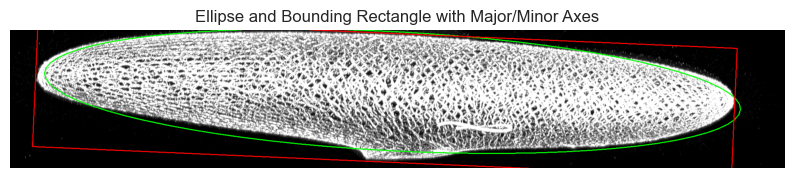

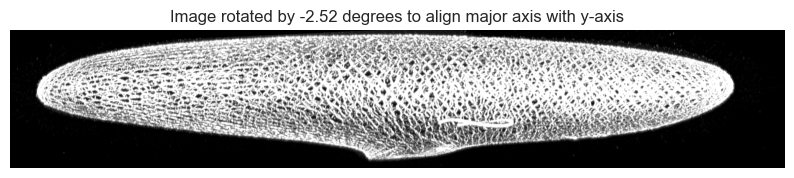

Angle of rotation to align major axis with y-axis: 2.52 degrees


In [85]:
#def preprocess_2d_projection(projection_2d_1, blur_size=9, canny_min=170, canny_max=200, close_size=5):
def preprocess_2d_projection(projection_2d_1, blur_size=3, canny_min=170, canny_max=200, close_size=5):
    if projection_2d_1 is None:
        raise ValueError("Input image is empty or not loaded correctly.")

    blur = cv2.blur(projection_2d_1, (blur_size, blur_size))
    canny = cv2.Canny(blur.astype(np.uint8), canny_min, canny_max)
    kernel = np.ones((close_size, close_size), np.uint8)
    closing = cv2.morphologyEx(canny, cv2.MORPH_DILATE, kernel)
    return closing

def find_shape(projection_2d_1, display=True):
    closing = preprocess_2d_projection(projection_2d_1)
    contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    longest_contour = max(contours, key=cv2.contourArea)

    if len(longest_contour) >= 5:
        ellipse = cv2.fitEllipse(longest_contour)
        image_ellipse = cv2.cvtColor(projection_2d_1, cv2.COLOR_GRAY2BGR)
        cv2.ellipse(image_ellipse, ellipse, (0, 255, 0), 2)

        rect = cv2.minAreaRect(longest_contour)
        box = cv2.boxPoints(rect)
        box = np.int32(box)
        cv2.drawContours(image_ellipse, [box], 0, (0, 0, 255), 2)

        center, size, angle = rect
        width, length = size if size[0] < size[1] else size[::-1]
        major_axis = length

        rect_center = np.array(center)
        half_major_axis_vector = np.array([-np.sin(np.deg2rad(angle)), np.cos(np.deg2rad(angle))]) * (major_axis / 2)
        major_axis_start = rect_center - half_major_axis_vector
        major_axis_end = rect_center + half_major_axis_vector

        if display:
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(image_ellipse, cv2.COLOR_BGR2RGB))
            plt.title("Ellipse and Bounding Rectangle with Major/Minor Axes")
            plt.axis('off')
            plt.show()

        return rect, (major_axis_start, major_axis_end)
    else:
        print("Not enough points to fit an ellipse.")
        return None, None

def rotate_image_to_align_major_axis_with_y_axis(image, rect, major_axis_vector):
    center, size, angle = rect

    # Calculate the rotation angle required to align the major axis with the y-axis
    major_axis_start, major_axis_end = major_axis_vector
    dx, dy = major_axis_end - major_axis_start
    rotation_angle = -np.degrees(np.arctan2(dx, dy))  # Calculate angle relative to y-axis
    # rotation_angle = 4 #manually chosen or adjusted

    # Rotate the image to align major axis with the y-axis (invert the angle for correct direction)
    rot_matrix = cv2.getRotationMatrix2D(tuple(center), rotation_angle, scale=1.0)
    rotated_image = cv2.warpAffine(image, rot_matrix, (image.shape[1], image.shape[0]))

    return rotated_image, rotation_angle

# Find shape and draw axes
rect, major_axis_vector = find_shape(projection_yz, display=True)

if major_axis_vector is not None:
    rotated_image, rotation_angle = rotate_image_to_align_major_axis_with_y_axis(projection_yz, rect, major_axis_vector)

    # Display the rotated result
    plt.figure(figsize=(10, 10))
    plt.imshow(rotated_image, cmap="gray")
    plt.title(f"Image rotated by {-rotation_angle:.2f} degrees to align major axis with y-axis")
    plt.axis('off')
    plt.show()
else:
    print("Could not find a valid shape in the image.")

#save the rotated image
output_file_rotated_yz = 'rotated_slices_xy_centrin_yz.tif'
io.imsave(output_file_rotated_yz, np.array(rotated_image))

# Print the angle of rotation
print(f"Angle of rotation to align major axis with y-axis: {rotation_angle:.2f} degrees")

# define angle of rotation to use later
rotation_angle_yz = rotation_angle

In [86]:
# apply yz rotation to the image stack: centrin
image_test = imageio.volread('rotated_slices_xy_centrin.tif')

# Normalize the z-axis
normalized_stack = np.zeros_like(image_test)
for i in range(image_test.shape[0]):
    normalized_stack[i] = image_test[i] * (Z_SCALE / X_SCALE)

# Apply the rotation to the ndarray
rotated_ndarray = rotate(normalized_stack, rotation_angle, reshape=True)

# Denormalize the z-axis
denormalized_stack = np.zeros_like(rotated_ndarray)
for i in range(rotated_ndarray.shape[0]):
    denormalized_stack[i] = rotated_ndarray[i] * (X_SCALE / Z_SCALE)

# Save the rotated image stack
imageio.volwrite('rotated_image_stack_yz_test_scaled.tif', denormalized_stack.astype(np.uint8))
imageio.volwrite(raw_data_file[:-4] + '_rotated_xy_yz.tif', denormalized_stack.astype(np.uint8))

In [87]:
# apply yz rotation to the image stack: poly-e
tiff_stack = io.imread('rotated_slices_xy_polyE.tif')

# apply same yz rotation to tiff_stack with normalized z-axis
normalized_stack2 = np.zeros_like(tiff_stack)
for i in range(tiff_stack.shape[0]):
    normalized_stack2[i] = tiff_stack[i] * (Z_SCALE / X_SCALE)

# Apply the rotation to the ndarray
rotated_tiff_stack = rotate(normalized_stack2, rotation_angle, reshape=True)

# Denormalize the z-axis
denormalized_stack2 = np.zeros_like(rotated_tiff_stack)
for i in range(rotated_tiff_stack.shape[0]):
    denormalized_stack2[i] = rotated_tiff_stack[i] * (X_SCALE / Z_SCALE)

# save the rotated image stack (polyE)
imageio.volwrite('rotated_image_stack_yz_polyE.tif', denormalized_stack2.astype(np.uint8))
imageio.volwrite(matching_files[0][0][:-4] + '_rotated_xy_yz.tif', denormalized_stack2.astype(np.uint8))